In [1]:
# Import Library
from google.colab import files
import zipfile
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# 1. Unggah dan ekstrak dataset ZIP
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [3]:
zip_path = "dataset.zip"
dataset_path = "dataset/dataset/Aksara Lampung"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Isi folder dataset:", os.listdir(dataset_path))

Isi folder dataset: ['dataset']


In [4]:
# 2. Membaca semua gambar dan label dari subfolder
IMAGE_SIZE = (224, 224)  # Ukuran gambar untuk model
image_files = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):
            image_files.append(os.path.join(root, file))
            # Label: hanya nama folder induk
            parent_folder = os.path.basename(os.path.dirname(root))
            labels.append(parent_folder)  # Gunakan hanya nama folder induk sebagai label

In [5]:
# 3. Konversi gambar ke array numerik dan resize
image_data = []
for img_path in image_files:
    img = Image.open(img_path).resize(IMAGE_SIZE).convert("RGB")
    image_data.append(np.array(img))

# Normalisasi gambar ke rentang 0-1
X = np.array(image_data, dtype="float32") / 255.0
y = np.array(labels)

In [6]:
# 4. Encode Label Menjadi Angka
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Total Kelas: {len(np.unique(y_encoded))}")
print(f"Contoh Label: {encoder.classes_}")

Total Kelas: 20
Contoh Label: ['A' 'Ba' 'Ca' 'Da' 'Ga' 'Gha' 'Ha' 'Ja' 'Ka' 'La' 'Ma' 'Na' 'Nga' 'Nya'
 'Pa' 'Ra' 'Sa' 'Ta' 'Wa' 'Ya']


In [7]:
# 5. Split Dataset: Train, Validation, dan Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (1238, 224, 224, 3), Validation set: (155, 224, 224, 3), Test set: (155, 224, 224, 3)


In [8]:
# 6. Membuat TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [9]:
# 7. Transfer Learning Menggunakan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Membekukan backbone agar tidak dilatih ulang

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Menambahkan lapisan fully connected
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Menggabungkan fitur dari backbone
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Output sesuai jumlah kelas
])

# 8. Compile model
optimizer = RMSprop(learning_rate=0.0001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 9. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 10. Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr, early_stop]
)

# 11. Evaluasi model pada test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Prediksi pada test set
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Label sebenarnya

# Hitung Precision, Recall, dan F1-Score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.0681 - loss: 3.2626 - val_accuracy: 0.2710 - val_loss: 2.5147 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2187 - loss: 2.5696 - val_accuracy: 0.5419 - val_loss: 2.1542 - learning_rate: 1.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3884 - loss: 2.1660 - val_accuracy: 0.6516 - val_loss: 1.8381 - learning_rate: 1.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5293 - loss: 1.8617 - val_accuracy: 0.7355 - val_loss: 1.5614 - learning_rate: 1.0000e-04
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5916 - loss: 1.6009 - val_accuracy: 0.8065 - val_loss: 1.3376 - learning_rate: 1.0000e-04
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6425 - loss: 1.3799 - val_accuracy: 0.8452 - val_loss: 1.1460 - learning_rate: 1.0000e-04
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6927 - loss:

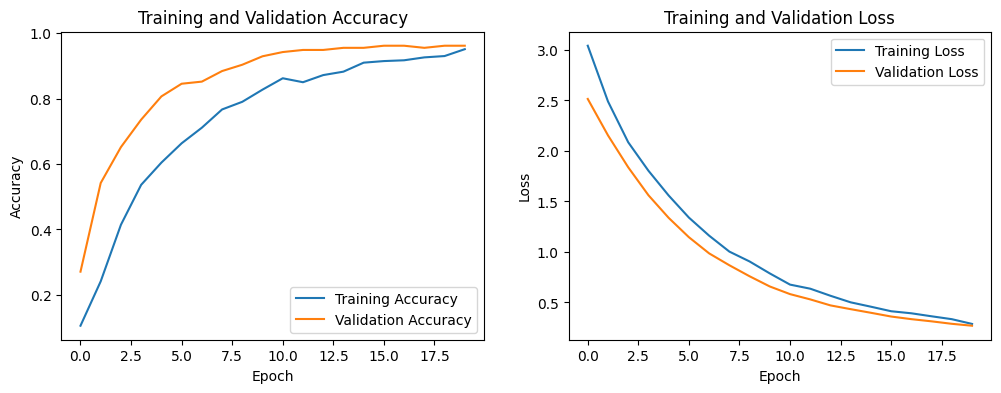

In [11]:
# 12. Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# Simpan model ke format HDF5
model.save('model_aksara_lampung_mobilenetv2_cnn.h5')

In [ ]:
model.save('model_aksara_lampung_mobilenetv2_cnn.keras')